In [203]:
# imports
from bs4 import BeautifulSoup
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings as warn
import seaborn as sns

warn.filterwarnings('ignore')

In [192]:
# read in data
corpus = pd.read_csv('data/posts.csv', index_col= 'Unnamed: 0')

# Quick Cleaning and Train Test Split

In [193]:
# drop na's
corpus.dropna(inplace = True)

# recode target variable
# 1 = Tech, 0 = Retail
corpus['subreddit'] = corpus['subreddit'].map({'TalesFromRetail': 0, 'talesfromtechsupport': 1})

# train test split data
X = corpus['selftext']
y = corpus['subreddit']
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size=0.33,
  random_state=8,
  stratify=y
)

# EDA

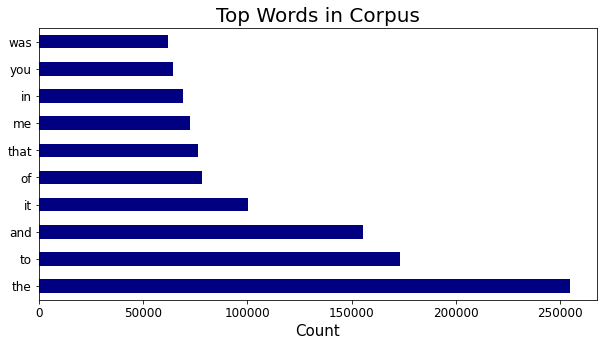

In [333]:
# most common words in whole corpus
cvec = CountVectorizer()
cvec.fit(X_train)
X_train_cvec = cvec.transform(X_train)
X_train_df = pd.DataFrame(X_train_cvec.todense(), columns= cvec.get_feature_names())
plt.figure(figsize = (10, 5))
X_train_df.sum().sort_values(ascending = False).head(10).sort_values(ascending = False).plot(kind = 'barh', color = 'navy')
plt.xlabel('Count', fontsize = 15)
plt.title('Top Words in Corpus', fontsize = 20);
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12);

- Our top words in the corpus are not helpful in classifying between subreddits, we should employ stopwords.

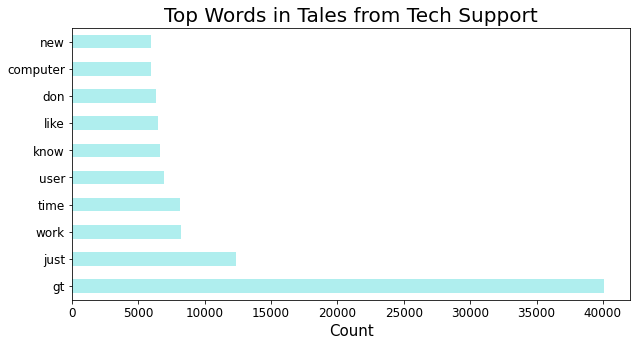

In [332]:
# most common words in Tech Support (y == 1), use stop words
cvec = CountVectorizer(stop_words='english')
cvec.fit(X_train)
X_train_cvec = cvec.transform(X_train)
X_train_df_1 = pd.DataFrame(X_train_cvec[y_train == 1].todense(), columns= cvec.get_feature_names())
plt.figure(figsize = (10, 5))
X_train_df_1.sum().sort_values(ascending = False).head(10).sort_values(ascending = False).plot(kind = 'barh', color = 'paleturquoise')
plt.xlabel('Count', fontsize = 15)
plt.title('Top Words in Tales from Tech Support', fontsize = 20);
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

In [128]:
X[231][:500]

'*cue Sara Mclachlan music*\n\nEvery year, millions of people are affected by this horrendous and life-shattering illness.  Merely by entering a retail establishment, they are struck dumb and lose the ability to form any coherent thoughts.\n\n*show a woman standing in front of a sign.  It reads "Children\'s shoes"*\n\n&gt; "Where are the kid\'s shoes?"\n\nPeople just like Karen here, who minutes before were literate members of society, cannot seem to make the connections in their mind between the words in '

- "\&gt" stands for the greater-than sign: >
- used to format blockquotes

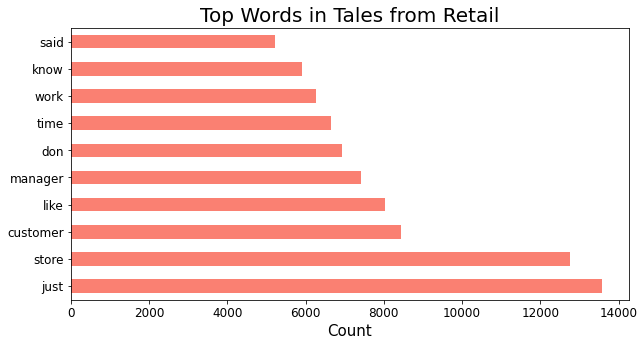

In [331]:
# most common words in Retail (y == 0), use stop words
X_train_df_0 = pd.DataFrame(X_train_cvec[y_train == 0].todense(), columns= cvec.get_feature_names())

plt.figure(figsize = (10, 5))
X_train_df_0.sum().sort_values(ascending = False).head(10).sort_values(ascending = False).plot(kind = 'barh', color = 'salmon');
plt.xlabel('Count', fontsize = 15)
plt.title('Top Words in Tales from Retail', fontsize = 20);
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

- "don" is an abbreviation of don't usually

In [130]:
# baseline accuracy
y.value_counts(normalize = True)

1    0.508101
0    0.491899
Name: subreddit, dtype: float64

- Our baseline accuracy is 50.8%, if we guessed 'talesfromtechsupport' every time

# MNB Model

In [131]:
pipe = Pipeline([
  ('tvec', TfidfVectorizer()),
  ('mnb', MultinomialNB())
])

pipe_params = {
    "tvec__max_features": [4930 , 4950, 4940, 4960],
    "tvec__stop_words"  : ["english"],
    "tvec__ngram_range" : [(1, 2)],
    "tvec__min_df"      : [0],
    "tvec__max_df"      : [.725]
    
}

gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5,
                  verbose = 100,
                  n_jobs= 7
                 )
gs.fit(X_train, y_train)

print(f'Gridsearch Best Score: {gs.best_score_}')
print('--------------------')

print(f'Gridsearch Best Params: {gs.best_params_}')
print('--------------------')

best_model = gs.best_estimator_
best_model.fit(X_train, y_train)
print(f'Testing Accuracy: {best_model.score(X_test, y_test)}')
print(f'Training Accuracy: {best_model.score(X_train, y_train)}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Gridsearch Best Score: 0.9773620471343808
--------------------
Gridsearch Best Params: {'tvec__max_df': 0.725, 'tvec__max_features': 4930, 'tvec__min_df': 0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
--------------------
Testing Accuracy: 0.9786700125470514
Training Accuracy: 0.9792938267789538
{'tvec__max_df': 0.725, 'tvec__max_features': 4930, 'tvec__min_df': 0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}


- Our training accuracy is slightly higher than our testing accuracy, suggesting our model's fit is slightly overfit, but not by a lot
- We settled on a Max DF of 72.5%, meaning that for a word to be included in our features it could not be present in more than 72.5% of documents. 
- Our Min DF was 0%, indicating that a word did not have to be present in more than one document to be considered a feature
- We had 4930 maximum number of features in our model

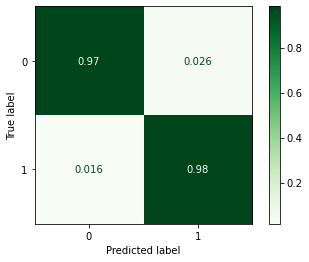

In [132]:
test_preds = best_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()
plot_confusion_matrix(best_model, X_test, y_test, cmap = 'Greens', normalize = 'true');


- We wrongly predicted 2.6% of the talesfromretail posts and 1.6% of talesfromtechsupport posts. These were the lowest false negative and false positive rates I could produce with the MNB model.

In [133]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3136
           1       0.97      0.98      0.98      3240

    accuracy                           0.98      6376
   macro avg       0.98      0.98      0.98      6376
weighted avg       0.98      0.98      0.98      6376



- Our accuracy, neg/pos precision, neg/pos recall, and f1 score were all ~.98

In [134]:
# set best parameters
max_df = gs.best_params_['tvec__max_df']
min_df = gs.best_params_['tvec__min_df']
max_features = gs.best_params_['tvec__max_features']
ngram_range = gs.best_params_['tvec__ngram_range']
stop_words = gs.best_params_['tvec__stop_words']

# find coefficients for each word
tvec = TfidfVectorizer(max_df=max_df, 
                       min_df=min_df, 
                       ngram_range=ngram_range, 
                       stop_words=stop_words, 
                       max_features=max_features)

X_train_tvec = tvec.fit_transform(X_train)
mnb = MultinomialNB()
mnb.fit(X = X_train_tvec, y = y_train)
coefs = mnb.coef_
coef_frame = pd.DataFrame(data = coefs.T, index = tvec.get_feature_names())
coef_frame.rename(columns = {0:'coef'}, inplace = True)

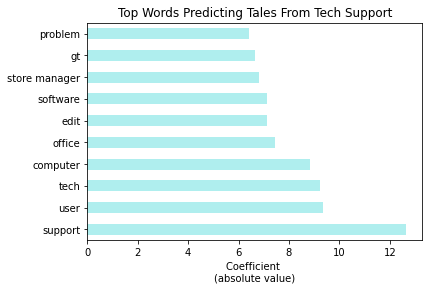

In [329]:
# top predictors of TechSupport
coef_frame['coef'].sort_values(ascending=False).head(10).abs().plot(kind = 'barh', color = 'paleturquoise')
plt.xlabel('Coefficient \n(absolute value)')
plt.title('Top Words Predicting Tales From Tech Support', fontsize = 12);

- NOTE: These coefficients are the feature log probabilities for each word

(0.0, 11.5)

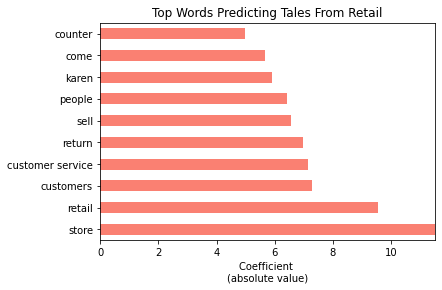

In [330]:
# top precictors of Retail
retail_top = coef_frame['coef'].sort_values(ascending=False).tail(10).abs().sort_values(ascending = False).plot(kind = 'barh', color = 'salmon')
plt.xlabel('Coefficient \n(absolute value)')
plt.title('Top Words Predicting Tales From Retail', fontsize = 12)
plt.xlim((0, 11.5));

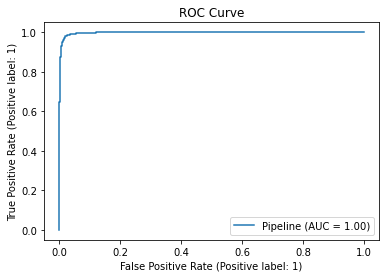

In [137]:
plot_roc_curve(best_model, X_test, y_test);
plt.title('ROC Curve');

- A good ROC curve compared to a "perfect" model, but not as good as our curve in the Log Reg model

# LogReg Model

In [143]:
pipe_2 = Pipeline([
  ('tvec', TfidfVectorizer()),
  ('logreg', LogisticRegression(penalty='elasticnet', 
                               random_state=42,
                               max_iter=5000,
                               verbose=1,
                               solver='saga'))
])

pipe_2_params = {
    "tvec__max_features": [5000],
    "tvec__stop_words"  : ["english"],
    "tvec__ngram_range" : [(1, 2)],
    "tvec__min_df"      : [0],
    "tvec__max_df"      : [.8],
    "logreg__C"         : [15],
    "logreg__l1_ratio"  : [0],
     
}

gs = GridSearchCV(pipe_2,
                  param_grid=pipe_2_params,
                  cv=5,
                  verbose = 1,
                  n_jobs=5
                 )

gs.fit(X_train, y_train)

print(f'Gridsearch Best Score: {gs.best_score_}')
print('--------------------')

print(f'Gridsearch Best Params: {gs.best_params_}')
print('--------------------')

best_model = gs.best_estimator_
best_model.fit(X_train, y_train)
print(f'Testing Accuracy: {best_model.score(X_test, y_test)}')
print(f'Training Accuracy: {best_model.score(X_train, y_train)}')


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 69 epochs took 1 seconds
Gridsearch Best Score: 0.9789072541480035
--------------------
Gridsearch Best Params: {'logreg__C': 15, 'logreg__l1_ratio': 0, 'tvec__max_df': 0.8, 'tvec__max_features': 5000, 'tvec__min_df': 0, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
--------------------


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 69 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


Testing Accuracy: 0.9819636135508155
Training Accuracy: 0.9983775013520823


- Our training accuracy is slightly higher than our testing accuracy, suggesting our model's fit is slightly overfit, but not by a lot
- We settled on a Max DF of 80%, meaning that for a word to be included in our features it could not be present in more than 80% of documents. 
- Our Min DF was 0%, indicating that a word did not have to be present in more than one document to be considered a feature
- We used a C value of 15 and l1 Ratio of 0
- We had 5000 maximum number of features in our model

<Figure size 864x864 with 0 Axes>

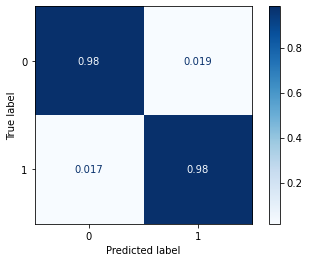

In [346]:
plt.figure(figsize = (12, 12))
test_preds = best_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()
plot_confusion_matrix(best_model, X_test, y_test, cmap = 'Blues', normalize = 'true');

- We incorrectly predicted 1.9% of the talesfromretail posts, and 1.7% of the talesfromtechsupport posts. This model did slightly better overall than the MNB model

In [148]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3136
           1       0.98      0.98      0.98      3240

    accuracy                           0.98      6376
   macro avg       0.98      0.98      0.98      6376
weighted avg       0.98      0.98      0.98      6376



- Precision, recall and f1 scores all 98%

In [154]:
# set best parameters
C = gs.best_params_['logreg__C']
l1_ratio = gs.best_params_['logreg__l1_ratio']
max_df = gs.best_params_['tvec__max_df']
min_df = gs.best_params_['tvec__min_df']
max_features = gs.best_params_['tvec__max_features']
ngram_range = gs.best_params_['tvec__ngram_range']
stop_words = gs.best_params_['tvec__stop_words']

# find coefficients for each word
tvec = TfidfVectorizer(max_df=max_df, 
                       min_df=min_df, 
                       ngram_range=ngram_range, 
                       stop_words=stop_words, 
                       max_features=max_features)

X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)
logreg = LogisticRegression(C=C, l1_ratio=l1_ratio)
logreg.fit(X_train_tvec, y_train)
coefs = logreg.coef_
coef_frame = pd.DataFrame(data = coefs.T, index = tvec.get_feature_names())
coef_frame.rename(columns = {0:'coef'}, inplace = True)

(5000, 1)

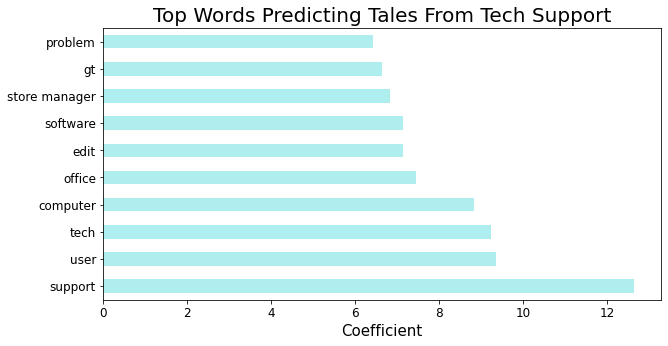

In [321]:
# top predictors of TechSupport
plt.figure(figsize = (10, 5))
coef_frame['coef'].sort_values(ascending=False).abs().head(10).plot(kind = 'barh', color = 'paleturquoise')
plt.xlabel('Coefficient', fontsize = 15)
plt.title('Top Words Predicting Tales From Tech Support', fontsize = 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

- Glad we kept 'gt' in, clearly the formatting of posts is important in the model
- Intuitive that "tech" and "support" are top words, considering that is the topic of the Subreddit
- 'store manager' is interesting, I would think that could also apply to Retail

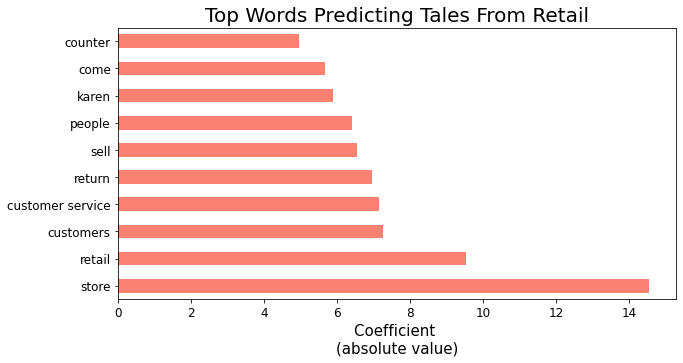

In [344]:
# top precictors of Retail
plt.figure(figsize = (10, 5))
coef_frame['coef'].sort_values(ascending=False).tail(10).abs().sort_values(ascending = False).plot(kind = 'barh', color = 'salmon')
plt.xlabel('Coefficient \n(absolute value)', fontsize = 15)
plt.title('Top Words Predicting Tales From Retail', fontsize = 20);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);


- 'Karen' is funny, is used to describe "a woman seeming to be entitled or demanding beyond the scope of what is normal."
- "Come" is interesting as well, I'm suprised that it is a top predictor considering it does not have a lot of meaning specific to retail

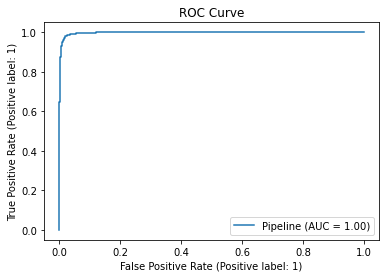

In [90]:
plot_roc_curve(best_model, X_test, y_test);
plt.title('ROC Curve');

- Model behavior looks close to "perfect model", which would look like a perfect right angle

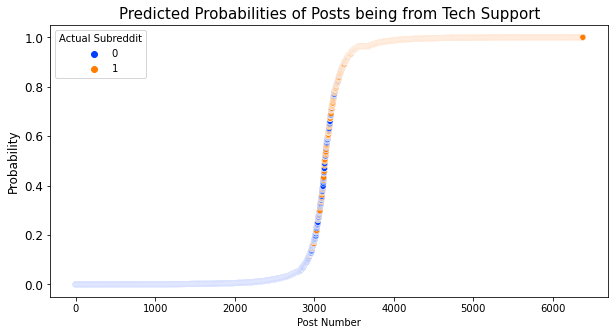

In [343]:
# create dataframe of predicted probabilities for each post, actual subreddit to create probability curve
prob_predict = pd.DataFrame(logreg.predict_proba(X_test_tvec), columns = ['Probability y = 0', 'Probability y = 1'])
prob_predict['Actual Subreddit'] = y_test.reset_index()['subreddit']
prob_predict['Predicted Subreddit'] = test_preds

# get nice S curve
prob_predict.sort_values(axis = 0, by = 'Probability y = 1', ascending=True, inplace=True)
prob_predict['ID'] = range(6376) 

# plot figure
plt.figure(figsize = (10, 5))
sns.scatterplot(x = prob_predict['ID'], 
                y = prob_predict['Probability y = 1'], 
                hue = prob_predict['Actual Subreddit'],
               palette = 'bright',
               alpha = 1)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 12)
plt.title('Predicted Probabilities of Posts being from Tech Support', fontsize = 15);
plt.ylabel('Probability', fontsize = 12)
plt.xlabel('Post Number', fontsize = 10);

- Model Probabilities from .2 to .8 have more errors than outside that range. Curve looks really good compared to "perfect model" with a step-wise shape

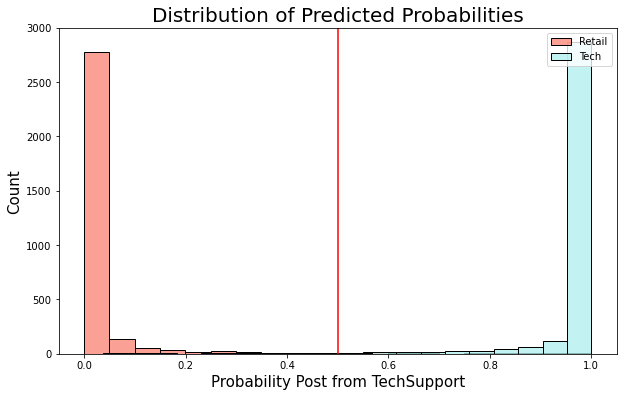

In [334]:
# plot histagram 
plt.figure(figsize = (10, 6))
sns.histplot(prob_predict.loc[prob_predict['Actual Subreddit'] == 0]['Probability y = 1'], 
             color = 'salmon', 
             bins = 20)
sns.histplot(prob_predict.loc[prob_predict['Actual Subreddit'] == 1]['Probability y = 1'], 
             color = 'paleturquoise',
            bins = 20)
plt.xlabel('Probability Post from TechSupport', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Distribution of Predicted Probabilities', fontsize = 20)
plt.ylim((0,3000));
plt.legend(['Retail', 'Tech'], loc='upper right')
plt.vlines(x = .5, ymin = 0, ymax=3500, color = 'red');


- Both ends look great, but let's zoom in so we can see the overlap

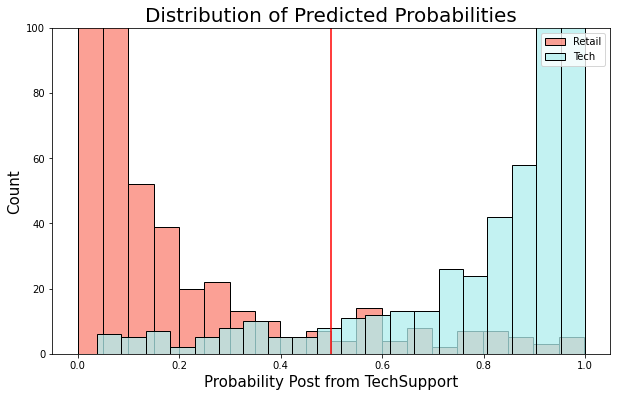

In [335]:
# zoom in
plt.figure(figsize = (10, 6))
sns.histplot(prob_predict.loc[prob_predict['Actual Subreddit'] == 0]['Probability y = 1'], 
             color = 'salmon', 
             bins = 20)
sns.histplot(prob_predict.loc[prob_predict['Actual Subreddit'] == 1]['Probability y = 1'], 
             color = 'paleturquoise',
            bins = 20)
plt.legend(['Retail', 'Tech'], loc='upper right')
plt.vlines(x = .5, ymin = 0, ymax=2500, color = 'red')
plt.xlabel('Probability Post from TechSupport', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Distribution of Predicted Probabilities', fontsize = 20)
plt.ylim((0,100));

- Definitely some errors in the 5-15 count range 
- Higher proportion of errors in probabilities ranging from .2 - .8

# False Predictions

In [340]:
# make dataframe of wrong predictions 
mask = [test_preds != y_test]
wrong_preds = np.array(X_test)[mask]
wrong_subs = np.array(y_test)[mask]
pred_subs = test_preds[mask]
wrong_df = pd.DataFrame(data = wrong_preds, columns = ['Subtext'])
wrong_df['Correct Subreddit'] = wrong_subs
wrong_df['Predicted Subreddit'] = pred_subs
wrong_df.head()

,Subtext,Correct Subreddit,Predicted Subreddit
0,Me: thank you for calling [REDACTED] my name i...,1,0
1,We have a special set of customers within our ...,1,0
2,"Forewarning, I don't work in IT. But what I di...",1,0
3,I work for a WISP in Northern California. One ...,1,0
4,"An older man came in, having been referred to ...",0,1


In [342]:
wrong_df.iloc[2]['Subtext']

'Forewarning, I don\'t work in IT. But what I did is essentially the job. \n\nMy gym is like a second home, but I am a complete nerd at home (and proud of it). The owners/desk lady\'s were complaining about their computer being slow for a while, and I knew they had an IT guy that came in every month (for security/accounts protection and Mait).\n\n&amp;#x200B;\n\nOne day, The receptionist was complaining for a good 30 minutes about it. And I finally snapped. I walked up, said I was taking a look and they could trust me (We were all on good terms, second family right?)  \n\n\nGOD KNOWS WHAT I FOUND. \n\n&amp;#x200B;\n\nAs soon as I got 3 feet from the comp area, I could smell it. The dark, dusty, burning of electronics. I was horrified. Seeing a space heater ON the tower, I asked how often she had it on.   \n\n\n"I have it on all the time, the Gym is air conditioned and I get so cold..."  \n\n\nKeep in mind, this is the owners daughter so I couldn\'t give a slap down, she also didn\'t kn

In [341]:
wrong_df.iloc[4]['Subtext']

'An older man came in, having been referred to Dr. A. Dr. A’s schedule was booked, but Dr. B, who was the same *type* of doctor, had availability. So when I started checking him in, I mentioned he was seeing Dr B.\n\n“What? No! I was referred to Dr A!”\n\n“Well, you’re seeing Dr B. She’s the same type of doctor, you’ll get the same treatment.”\n\n“You can’t make me see one doctor when I was referred to another! That’s malpractice! It’s like needing to get your left foot cut off but they cut off your right foot!”\n\nYes, he said that. I then had to grab a pamphlet for Dr B and show the patient that she was qualified.\n\n“‘Dr B is a qualified UNSPECIFIED-ologist,’” I read aloud. “She began her education at SCHOOL in the West Indies...”\n\n“West Indies?” The man muttered. “So she couldn’t get into a school in the States, huh?”\n\n“‘...before attending SCHOOL in New York,’” I continued.\n\nHe finally acquiesced after reading the pamphlet for himself and deeming Dr B worthy of his time.'

- Both of these are examples of misclassified posts in our model. When we examine them, it is pretty clear why. 
- The top one was misclassified as Retail, and it even says in the first sentence of the post "I don't work in IT." The story does have to do with tech support, but given that this is someone not familiar with the posting format ("Sorry for format, first post here"), it makes sense why it was misclassified.
- The bottom one does not even have to do with retail, it has to do with a receptionist at an Doctors office. It really doesn't belong in either subreddit. 